In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import sys

sys.path.append("../")

import torch
from models.vae import VAE
from models.sae import SAE
from vae_interp.controls import FeaturesControls
from dataset import load_nouns_dataset, NpyDataset
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from utils import make_image_grid

In [3]:
vae = VAE.load_from_dir("../weights/vae")
sae = SAE.load_from_checkpoint("../weights/sae/config.json",
                               "../weights/sae/sae.pth")
path = "../checkpoints/sae_awesome/lr=5.0e-03_l1=1.0e-02"
# path = "../checkpoints/eric/lr=1.0e-03_l1=1.0e-02"
sae = SAE.load_from_checkpoint(f"{path}/config.json",
                               f"{path}/sae.pth")

In [5]:
nouns_dataset = load_nouns_dataset(image_size=64, normalize=True)

In [6]:
features_controls = FeaturesControls(
    sae=sae, vae=vae, latent_shape=(4, 4, 4)
)

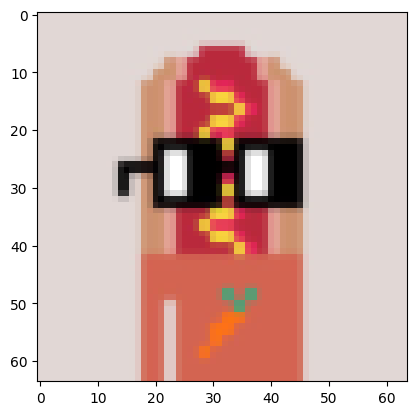

In [7]:
idx = 0
image = nouns_dataset[idx]
original_image = nouns_dataset.dataset[idx]["image"]

plt.imshow((image.permute(1, 2, 0) + 1) * 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013233602..1.0104262].


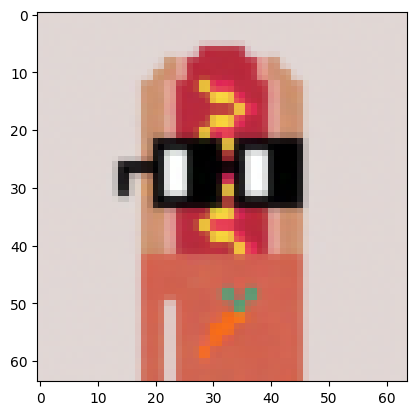

In [9]:
with torch.no_grad():
    recon = vae(image.unsqueeze(0))["recon"]

plt.imshow((recon.squeeze().permute(1, 2, 0) + 1) * 0.5)

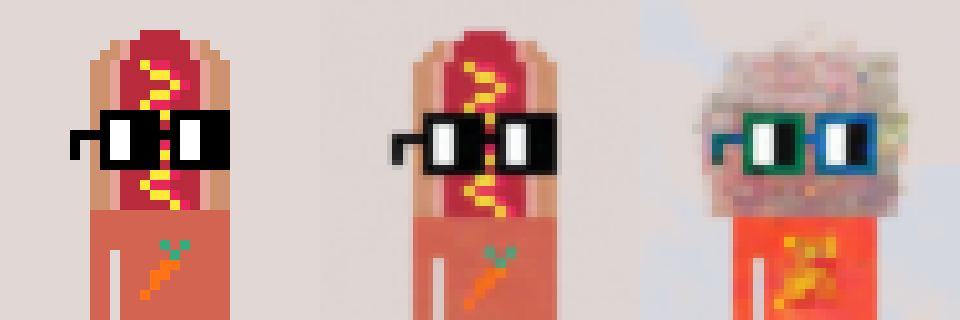

In [32]:
with torch.no_grad():
    recon = vae(image.unsqueeze(0))["recon"]

vae_recon = torch.clamp((recon - recon.min()) / (recon.max() - recon.min()), 0, 1)
vae_recon = ToPILImage()(vae_recon.squeeze())

with torch.no_grad():
    mu, _ = vae.encode(image.unsqueeze(0))
    mu = mu.view(1, -1)
    c = sae.encode(mu)
    sae_recon_latent = sae.decode(c).view(1, 4, 4, 4)
    sae_recon = vae.decode(sae_recon_latent).squeeze()
    
sae_recon = torch.clamp((sae_recon - sae_recon.min()) / (sae_recon.max() - sae_recon.min()), 0, 1)
sae_recon = ToPILImage()(sae_recon)

make_image_grid([original_image, vae_recon.resize((330, 330), 0), sae_recon.resize((330, 330), 0)], 1, 3)

In [14]:
with torch.no_grad():
    mu = vae(image.unsqueeze(0))["mu"]

mu.shape

torch.Size([1, 4, 4, 4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0893435..0.99240845].


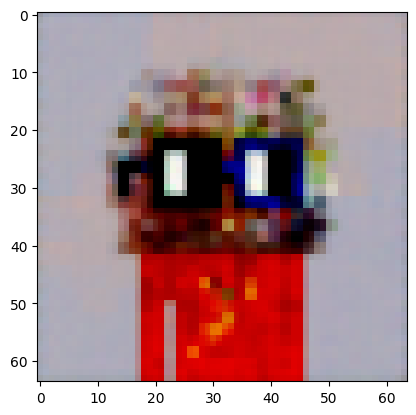

In [11]:
with torch.no_grad():
    latents = vae.encode(image.unsqueeze(0))[0].view(1, -1)
    recon_latents = sae(latents).recon
    recon_latents = recon_latents.view(-1, *(4, 4, 4))
    recon_images_from_recon_latents = vae.decode(recon_latents)[0]
    recon_images_from_recon_latents.shape

recon_images_from_recon_latents = recon_images_from_recon_latents.permute(1, 2, 0)
plt.imshow(recon_images_from_recon_latents)

In [12]:
features = features_controls.get_features(image)
features

{100: 0.1891501247882843,
 207: 0.5502895712852478,
 242: 0.29817458987236023,
 281: 0.04382095858454704,
 322: 0.790120542049408,
 384: 0.30303409695625305,
 542: 0.7686414122581482,
 547: 0.04183696210384369,
 631: 0.21534113585948944,
 647: 0.1484888792037964,
 665: 0.0467647947371006,
 706: 0.7275840640068054,
 758: 0.09741059690713882,
 808: 0.024027682840824127,
 818: 0.3337452709674835,
 838: 0.11515413969755173,
 849: 0.2079351842403412,
 910: 0.5481215715408325,
 915: 0.3616200089454651,
 947: 0.10770411789417267,
 1007: 1.0209746360778809}

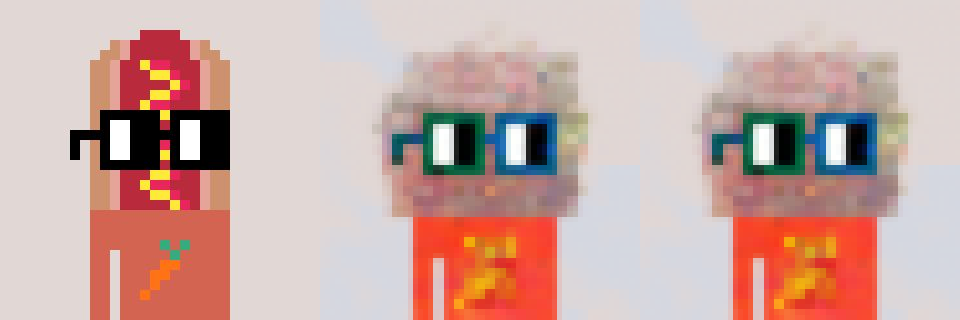

In [13]:

# features_ = {x["feature_id"]: x["activation"] for x in features}
# print(features_)
new_features ={
    # 1007: 0
}

# new_features[197] = 0
# new_features[1019] = 0

import torch
modified_image = features_controls.modify_features(image, new_features)
# modified_image = (modified_image - modified_image.min()) / (modified_image.max() - modified_image.min())
modified_image = torch.clamp((modified_image + 1) * 0.5, 0, 1)  
# modified_image = modified_image.permute(1, 2, 0)

from utils import make_image_grid
from torchvision.transforms import ToPILImage
from PIL import Image

sae_recon = features_controls.modify_features(image, features)
sae_recon = torch.clamp((sae_recon + 1) * 0.5, 0, 1)
sae_recon = ToPILImage()(sae_recon).resize((330, 330), 0)

modified_image = ToPILImage()(modified_image).resize((330, 330), 0)

make_image_grid([
    original_image,
    sae_recon,
    modified_image
], rows=1, cols=3)